# A/B Example from Website

## Code Source and Article

### Please read
I copied the author's code and commentary. Kudos to Samuel Hinton for sharing. 

-   Check out Sam's [link](https://cosmiccoding.com.au/tutorials/ab_tests)

-   I will also put in some extra details and comments as I follow his example.

-   It's been awhile for me and probably for others, so I added some theory to help understand his examples

<h2>Table of content</h2>

<div class="alert alert-block alert-info" style="margin-top: 20px">
<ol>
    <li><a>Modelling click through</a></li>
    <li><a>Let's get normal</a></li>
    <li><a>Can we check we've done the right thing?</a></li>
    <li><a>Can we do this test even faster?</a></li>
</ol>
    
</div>
 
<hr>


<h4>Important Concepts</h4> Copy from source - I wanted to include them as a reference

[Wikipedia](https://en.wikipedia.org/wiki/Bernoulli_distribution) ; [Go to here for more details](https://towardsdatascience.com/understanding-bernoulli-and-binomial-distributions-a1eef4e0da8f)<h6> Bernoulli Distribution </h6> 

The Bernoulli distribution is the discrete probability distribution of a random variable which takes a binary, boolean output: 
- 1 with probability p
- 0 with probability (1-p). 

\begin{equation*}
X \sim Be(p) = f(x) = p^x (1-p)^{1-x} \\
E[X]=p \\
Var[X]=p(1-p)
\end{equation*} 

<h6> Binomal Distribution </h6> 

This distribution describes the behavior the outputs of $n$ random experiments, each having a Bernoulli distribution with probability $p$.

The <font color='blue'><b>binomal</b></font> probability mass function ($Y$) is:
\begin{equation*}
\sum_{i=1}^n X_{i} =  Y \\
Y \sim Bin(n,p) = f(k) = {n \choose k} p^k (1-p)^{n-k} \text{  ,  } k \in \{0, 1,..., n\} \\
E[Y]=np \\
Var[Y]=np(1-p)
\end{equation*} 

    n: The number of trials in the binomial experiment
    k: The number of successes that result from the binomial experiment 
    p: The probability of success on an individual trial

If $Y \sim Bin(n, p)$ and if n is large (Central Limit Theorem), then
 - $\frac{Y}{n}$ could be approximated by $Normal\left(\mu=p, \sigma^{2}= \frac{\sigma^2_{Bernolli}}{n}=\frac{pq}{n}\right)$

<h6> Why is it important to talk about this now?? </h6> 
In below example, we are interested in the <b> average</b> of our sample independent Bernoulli trials in this experiment. So this means that we fill be focusing on
\begin{equation*}
\frac{1}{n}\sum_{i=1}^n X_{i} = \bar{X}
\end{equation*} 

- How we calculate the expected sample mean and variance?
\begin{equation*}
E\left[ \frac{1}{n}\sum_{i=1}^n X_{i}\right]=E\left[\frac{Y}{n}\right]=\frac{1}{n} E\left[Y\right]=\frac{1}{n}\left(np\right)=p
\end{equation*} 

\begin{equation*}
Var\left[ \frac{1}{n}\sum_{i=1}^n X_{i}\right]=Var\left[\frac{Y}{n}\right]=\frac{1}{n^2} Var\left[Y\right]=\frac{1}{n^2}\left(npq\right)=\frac{pq}{n} \\
\text{where } q = 1-p
\end{equation*} 



<h3>What is an AB Test? </h3>

Suppose you have 2 websites. Will the <font color='red'>red button</font>  change I made increase conversion?
1. Old Website (A in the picture) 
2. New Webiste (B in the picture)

![AB Test](https://cosmiccoding.com.au/static/img/tutorials/abtests/2020-01-12-ABTests_1_0.jpg)

<b>Experiment Setup:</b> By having two sites active at once and randomly directing users to one or the other, you control for all variables.

<b> Common Metrics to test in A/B test:</b> Click through/conversion, bounce rate, and how long you spend on the page. For the example, let us assume we want to optimise conversion, which in our case ic click the "Add to cart" button 

<h2 id="">Setup</h2>


 Import libraries 


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.stats.api as sms

from scipy.stats import binom
from scipy.stats import mannwhitneyu
from scipy.stats import norm
from scipy.stats import ttest_ind
import emcee

import seaborn as sns
import statsmodels.stats.api as sms
from math import ceil

## 1. Modeling click through -- Site A & Site B

<h3> 1a. Understanding our sample experiment - We have binary outcomes </h3>Suppose we have a total of 1000 users

|                      | Directed to A | Directed to B | Total |
|----------------------|:-------------:|:-------------:|:-----:|
| # of Users           | 550           | 450           | 1000  |
| # of Users Converted | 48            | 56            | 104   |
| % of Users Converted | 8.73%         | 12.44%        | 10.4% |



In [2]:
num_a, num_b = 550, 450 # Represents n
click_a, click_b = 48, 56 # Represents k
rate_a, rate_b = click_a / num_a, click_b / num_b # Represents p
print("Rate A: %.4f ; Rate B: %.4f" % (rate_a, rate_b) )
print("Sample Rate difference between Site B and Site A: %.4f" % (rate_b - rate_a))

Rate A: 0.0873 ; Rate B: 0.1244
Sample Rate difference between Site B and Site A: 0.0372


We have two discrete options **(Click Button, or not)** available, so this is textbook **binomal distribution**, with some unknown rate for site A and site B. 

Remember:
- n: The number of trials in the binomial experiment 
- k: The number of successes that result from the binomial experiment 
- p: The probability of success on an individual trial

[Scipy binom Documentation](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.binom.html#scipy.stats.binom)

In the scipy library, `binom` takes `n` and `p` as shape parameters.

```python
scipy.stats.binom(*args, **kwds).pmf(k, n, p, loc=0) 
= Probability mass function
``` 

<h3> 1b. Plotting the binomal distribution </h3>

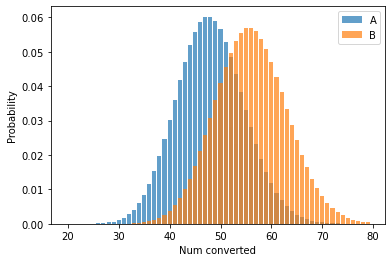

In [3]:
import matplotlib.pyplot as plt
from scipy.stats import binom
import numpy as np

# Determine the probability of having k number of click throughs
clicks = np.arange(20, 80) #For Binom functions, try k={20,21,22...79} 
prob_a = binom(num_a, rate_a).pmf(clicks) #get probability mass function for binomal distribution
prob_b = binom(num_b, rate_b).pmf(clicks)

# Make the bar plots.
plt.bar(clicks, prob_a, label="A", alpha=0.7)
plt.bar(clicks, prob_b, label="B", alpha=0.7)
plt.legend()
plt.xlabel("Num converted"); plt.ylabel("Probability");

<b>Samuel Hinton: </b> 

So we can see here that `B` has an edge, but its <u>certaintly possible</u> if we pick <u>two random points</u> according to the histograms for `A` and `B`, that `A`  <b>might actually be higher than</b> `B`!

## 2. Let's get normal


<h3> 2a. Using Normal Distributions to approximate binomal distributions </h3>

<b><u>Samuel Hinton:</u></b> 

Sure, we can work with binomial distributions in this case. And Poisson distributions in the “How long were you on the site” case. 

We could swap for every question<b>… or we can invoke the Central Limit Theorem</b>. 
   - As we’re interested in the <font color=blue><b>average</b> conversion, or <b>average</b> time spent on the site</font>
   - This averaging of an underlying distribution means our final estimate will be well approximated by a normal distribution. 

So let’s reformulate, [using the normal approximation here](https://en.wikipedia.org/wiki/Binomial_distribution#Normal_approximation), [link on Variance properities](https://en.wikipedia.org/wiki/Variance#Sum_of_uncorrelated_variables_.28Bienaym.C3.A9_formula.29) and [Scipy norm Documentation](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.norm.html)

- <b> Harry - Recall: </b>
\begin{equation*}
E\left[ \frac{1}{n}\sum_{i=1}^n X_{i}\right]=E\left[\frac{Y}{n}\right]=\frac{1}{n} E\left[Y\right]=\frac{1}{n}\left(np\right)=p
\end{equation*} 

\begin{equation*}
Var\left[ \frac{1}{n}\sum_{i=1}^n X_{i}\right]=Var\left[\frac{Y}{n}\right]=\frac{1}{n^2} Var\left[Y\right]=\frac{1}{n^2}\left(npq\right)=\frac{pq}{n} \\
\text{where } q = 1-p
\end{equation*} 

If $Y \sim Bin(n, p)$ and if n is large (Central Limit Theorem), then
 - $\frac{Y}{n}$ could be approximated by $Normal\left(\mu=p, \sigma^{2}= \frac{\sigma^2_{Bernolli}}{n}=\frac{pq}{n}\right)$
 
In the scipy library, `norm` takes 2 arugments: `loc`(mean) and `scale`(standard deviation).

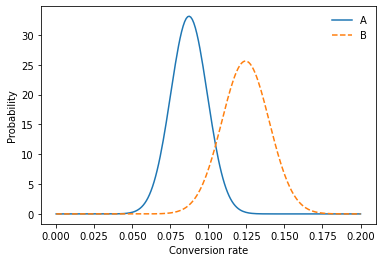

In [4]:
from scipy.stats import norm

# Where does this come from? See the link above.
std_a = np.sqrt(rate_a * (1 - rate_a) / num_a) #He is calculating the sample standard deviation
std_b = np.sqrt(rate_b * (1 - rate_b) / num_b)

click_rate = np.linspace(0, 0.2, 200) # Let plot pdf from 0 to 0.2; 200 steps
prob_a = norm(rate_a, std_a).pdf(click_rate) #get probability dentisity function based normal distribution
prob_b = norm(rate_b, std_b).pdf(click_rate)

# Make the line plots.
plt.plot(click_rate, prob_a, label="A")
plt.plot(click_rate, prob_b, label="B", linestyle='dashed')
plt.legend(frameon=False)
plt.xlabel("Conversion rate"); plt.ylabel("Probability");

<font color='red'><b>Sam:</b></font> By normalizing, we've removed the confusing effect of site A and site B having a slightly different number of vistors had.

1. What is the chance that a draw from B is higher from A
2. Is it significant?

<h3>2b. We will examine the difference of the Normal Distributions of Site A versus Site B</h3>

To answer this, let us utilise the handy fact that the sum (or difference) of normally <b>independent</b> distributed random numbers is also a normal. [See here for the proof](https://en.wikipedia.org/wiki/Sum_of_normally_distributed_random_variables#Independent_random_variables), but the math is as follows:

$$ P(b-a) = \mathcal{N}\left(\mu_{B-A}=\mu_B - \mu_A, \sigma^{2}_{B-A}=\sigma_B^2 + \sigma_A^2 \right) $$

<b>Harry:</b> 
- I think he should mentioned about independent. 
- He's going to use this fact when  we analyze our samples


<b>Harry: </b> For this 1-tailed test
- $H_0$ We first assume that the mean rates of site B and site A are equal 
- $H_1$ We want to see if there is enough evidence to reject null hypothesis, and state B>A 

$$H_0 : \mu_B=\mu_A \\
H_1 : \mu_B>\mu_A \\
$$
Essentially, you could view the alternative hypothesis $H_1$ as the below
$$P(b>a)=P(b-a>0)$$

For below code, recall the formula Z-Score
$$z=\frac{x-\mu}{\sigma} $$

<b>Sam: </b>This is simple - take the difference in the means and sum the variance. We’ll do two things below: First, get the z-score, and second, plot the proper distribution.

Zscore is 1.890, with p-value 0.029


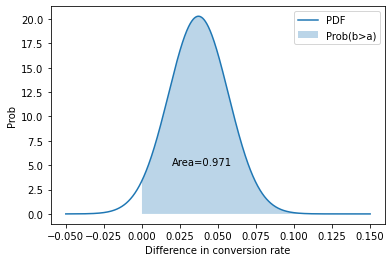

In [5]:
# Calc Z-score for our sample difference between B and A
# with the assumption that the actual (aka population) 
# difference between B and A is 0
z_score = (rate_b - rate_a) / np.sqrt(std_a**2 + std_b**2)

# Normal Distribution of the difference between site B and site A
p = norm(rate_b - rate_a, np.sqrt(std_a**2 + std_b**2))

x = np.linspace(-0.05, 0.15, 1000)
y = p.pdf(x)
area_under_curve = p.sf(0) #Essentially 1-cdf for z-score of 0
plt.plot(x, y, label="PDF")
plt.fill_between(x, 0, y, where=x>0, label="Prob(b>a)", alpha=0.3)
plt.annotate(f"Area={area_under_curve:0.3f}", (0.02, 5))
plt.legend()
plt.xlabel("Difference in conversion rate"); plt.ylabel("Prob");

# #Survival function (also generalized as 1 - cdf), 
# but sf is sometimes more accurate).
print(f"Zscore is {z_score:0.3f}, with p-value {norm().sf(z_score):0.3f}") 

In [6]:
# Instead of p-value, you could also see cdf
print("Cumulative distribution of z-score: %.7f" % (norm().cdf(z_score)))

# the sample difference
print("Our sample difference (B-A): %.4f" % (rate_b - rate_a))

Cumulative distribution of z-score: 0.9705973
Our sample difference (B-A): 0.0372


<b>Sam </b> Great! So, how to phrase this result? 
- Using our frequentist approach so far, we would say that given the null hypothesis is true (that B is less then or equal to A), <b><u>we would expect to get this result or a result more extreme only 2.9% of the time. </u></b>
- As that is a significant result (typically p < 5%), we reject the null hypothesis, and state that we have evidence that B > A.

We should explicitly note here that this is a one-tailed test - the question we’ve asked is if B > A. 

<b>An alterative is the two-tailed test, where we just want to discriminate that B is different to A.</b> 
- In that case, our p-value is actually $2*2.9=5.8$ percent (as we have two tails, not one)
- We would want more samples before rejecting the null hypothesis if we stick to the p-value of 0.05 percent threshold.

<b>Harry </b> I like Sam's explanation and the graph we just made. Another way of thinking, we just calcuated the <b>Type 1 error</b> (reject a true null hypothesis). There is a 2.9% chance we were wrong to reject the null hypothesis.

![cool image](http://www.personal.ceu.hu/students/08/Olga_Etchevskaia/images/errors.jpg)

<h3>2c. Let's just simplify what we just did</h3>

<b>Sam:</b> However, we’ve made a lot of plots for this to try and explain the concept. You can easily write a tiny function to simplify all of this. Whether you want the confidence or the p-value just means changing the final <code><font color='crimson'>norm.cdf</font></code> to <code><font color='crimson'>norm.sf</font></code> 


In [7]:
# Num Conv for A, Total Users A, Num Conv for B, Total Users B
def get_confidence_ab_test(click_a, num_a, click_b, num_b):
    rate_a = click_a / num_a
    rate_b = click_b / num_b
    std_a = np.sqrt(rate_a * (1 - rate_a) / num_a) #sample std for A
    std_b = np.sqrt(rate_b * (1 - rate_b) / num_b) #sample std for B
    z_score = (rate_b - rate_a) / np.sqrt(std_a**2 + std_b**2)
    return norm.cdf(z_score)

print(get_confidence_ab_test(click_a, num_a, click_b, num_b))

0.9705973498275782


## 3. Can we check we've done the right thing?

In [8]:
# Draw 10000 samples of possible rates for a and b
n = 10000

# Get N random samples for Site A and Site B, 
# based on normalized distribution
rates_a = norm(rate_a, std_a).rvs(n) 
rates_b = norm(rate_b, std_b).rvs(n)

#Determine the number of times when B is greater than A
b_better = (rates_b > rates_a).sum() / n

print(f"B is better than A {b_better * 100:0.1f}% of the time")

B is better than A 97.0% of the time


<b>Sam:</b> 
Which, rephrased to the language of before, is that $A > B$ only $2.9\text{%}$ of the time, which is statistically significant such that <u>we can reject our null hypothesis</u> (that $A <= B$).


In [9]:
rates_a[0:5] #looking at the first 5 samples rates of conversion for site A

array([0.08641403, 0.1071461 , 0.10768395, 0.07965207, 0.0809472 ])

In [10]:
rates_b[0:5] #looking at the first 5 samples rates of conversion for site b

array([0.11682689, 0.10913186, 0.11939957, 0.12515559, 0.12656525])

## 4. Can we do this test faster? Use some libraries !


Imagine we have the <b>raw results</b> of click through, 0 or 1, as our distribution, and we want to use an inbuild <font color='red'><b>t-test</b></font>.  For a two-sided test,

$$H_0 : \mu_B=\mu_A \\
H_1 : \mu_B\neq\mu_A \\
$$

### 4a. Welsch's t-test

[Click here for ttest documentation](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ttest_ind.html)

In [14]:
from scipy.stats import ttest_ind
a_dist = np.zeros(num_a) # Create array of 0s for Site A
a_dist[:click_a] = 1     # For first K entries, put 1 for convert
b_dist = np.zeros(num_b)
b_dist[:click_b] = 1
zscore, prob = ttest_ind(a_dist, b_dist, equal_var=False) #use False
print(f"Zscore is {zscore:0.2f}, p-value is {prob:0.3f} (two tailed), {prob/2:0.3f} (one tailed)")

Zscore is -1.89, p-value is 0.059 (two tailed), 0.030 (one tailed)


<font color='red'><b>Sam</b></font>

Note here that the p-value by default is using the two-tailed test. We can see these values are almost identical to the ones we computed ourselves… but they’re not exactly the same. 

Why is this? 

1. Well, the ttest_ind (with equal_var=False) is running Welch’s t-test. 
2. The t-test has degrees-of-freedom which will induce subtle differences with the normal approximation. 
3. Additionally, <b>Welsch’s t-test is meant for continuous data</b>, we have discrete 0 and 1 options. 
4. A better option for discrete data is the Mann-Whitney U statistic.

<b>Harry - Recall</b>
``` python
num_a, num_b = 550, 450 # Represents n
click_a, click_b = 48, 56 # Represents k

ttest_ind(a, b, axis=0, equal_var=True, nan_policy='propagate')
```
<b>equal_varbool, optional </b>
1. If True (default), perform a standard independent 2 sample test that assumes 
2. If <b>False</b>, perform Welch’s t-test, which does not assume equal population variance 


### 4b. Mann-Whitney U test

[Click here for SCIPY documentation](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.mannwhitneyu.html)

In [17]:
from scipy.stats import mannwhitneyu
stat, p_value = mannwhitneyu(a_dist, b_dist, alternative="less")
print(f"Mann-Whitney U test for null hypothesis B <= A is {p_value:0.3f}")

Mann-Whitney U test for null hypothesis B <= A is 0.028


<b>Sam</b>

1. P-value is low and we can reject the null hypthesis. 

2. Noticed too that we have <code><font color='crimson'>alternative="less"</font></code>, which is the null hypothesis that we are testing so that we can investigate if <code><font color='crimson'>B > A</font></code>.

<b>Harry</b>

1. In other words, he's saying this
    1. Null hypothesis <font color='crimson'>$A \geq B$</font>
    2. Alternative hypothesis <font color='crimson'>$A < B$</font>

``` python
alternative{None, ‘two-sided’, ‘less’, ‘greater’}, optional
```
Defines the alternative hypothesis. The following options are available (default is None):

            None: computes p-value half the size of the ‘two-sided’ p-value and a different U statistic. The default behavior is not the same as using ‘less’ or ‘greater’; it only exists for backward compatibility and is deprecated.

            ‘two-sided’

            ‘less’: one-sided

            ‘greater’: one-sided

### 4c. Bayesian Approach



In [19]:
import numpy as np

def get_prior(x):
    p, delta = x
    if not 0 < p < 1:
        return -np.inf
    if not 0 < p + delta < 1:
        return -np.inf
    if not -0.1 < delta < 0.1:
        return -np.inf
    return 0

def get_likelihood(x):
    p, delta = x
    return norm().logpdf((p - rate_a) / std_a) + norm().logpdf((p + delta - rate_b) / std_b)

def get_posterior(x):
    prior = get_prior(x)
    if np.isfinite(prior):
        return prior + get_likelihood(x)
    return prior

In [20]:
import emcee
ndim = 2  # How many parameters we are fitting. This is our dimensionality.
nwalkers = 30  # Keep this well above your dimensionality.
p0 = np.random.uniform(low=0, high=0.1, size=(nwalkers, ndim))  # Start points
sampler = emcee.EnsembleSampler(nwalkers, ndim, get_posterior)
state = sampler.run_mcmc(p0, 1000)  # Tell each walker to take some steps

chain = sampler.chain[:, 200:, :]  # Throw out the first 200 steps
flat_chain = chain.reshape((-1, ndim))  # Stack the steps from each walker
print(flat_chain)

[[0.08556736 0.05889887]
 [0.07708193 0.05569577]
 [0.0735285  0.06304955]
 ...
 [0.07191659 0.06937792]
 [0.07191659 0.06937792]
 [0.07191659 0.06937792]]


Great, so we have samples from the posterior, but this doesn’t mean much. Lets throw them into chainconsumer.

In [21]:
from chainconsumer import ChainConsumer
c = ChainConsumer()
c.add_chain(flat_chain, parameters=["$P_A$", "$\delta_P$"], kde=1.0)
c.configure(flip=False)
c.plotter.plot();

ModuleNotFoundError: No module named 'chainconsumer'

### Closing Thoughts

In general, the One-way ANOVA F-test could be generalized as being reserved for three or more groups, where as the  T-Test is reserved when dealing with two groups.

